In [67]:
# Time Independent Schrodinger Equation
# Computational Physics Project 2, Spring 2017
# Ben Zager and Christopher Meierfrankenfeld

import numpy as np
import scipy as sp
from scipy.integrate import odeint,simps
from scipy.optimize import brentq,brenth,newton,bisect,ridder
from scipy.special import airy
import matplotlib.pyplot as plt

In [68]:
# Physical and numerical parameters

L = 10.0 # length to approximate as infinity
nx = 100 # number of grid points

x = np.linspace(0,L,nx) # grid
psi0 = 0; u0 = 1; # initial conditions
init = np.array([psi0,u0]) # 
E = 1 # Energy

# potential function
def V(x):
    return linear(x)
    #return harmonic(x)

# Semi-infinite triangular potential
def linear(x):
    if x==0:
        return 10000 # some very large number
    else:
        return x
    
def harmonic(x):
    return x**2

# psi update function
def f(psi,u,x,E):
    return u

# u update function
def g(psi,u,x,E):
    return 2*(V(x)-E)*psi


In [69]:
# define ODE solvers

# return derivatives for odeint
def deriv(sol,x,E):
    psi,u = sol
    dpsi = f(psi,u,x,E)
    du = g(psi,u,x,E)
    
    return np.array([dpsi,du])

# solves ode for given energy E
def odeSolve(init,x,E):
    sol = odeint(deriv,init,x,args=(E,))
    
    return sol

#counts the number of time that psiAtL is called
evalcount=0

# solves ode for given E and returns value "at L"

def psiAtL(E,init,x, evalcount= [0] ):
    sol = odeint(deriv,init,x,args=(E,))
    evalcount[0]=evalcount[0]+1
    return sol[-1,0]

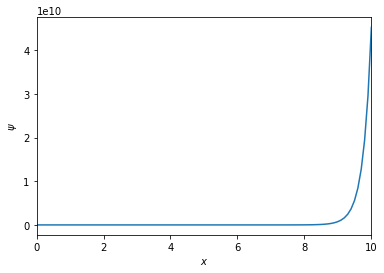

In [70]:
# Test solver and plot

sol = odeSolve(init,x,E)
psi = sol[:,0]; u = sol[:,1]

plt.plot(x,psi)
plt.xlabel(r"$x$"); plt.ylabel(r"$\psi$")
plt.xlim([0,L]); #plt.ylim([-1,1]);

#plt.axhline(0,color='k'); plt.grid(True);
#plt.savefig("figures/testPlot_L="+str(int(L))+".png")
plt.show()

In [71]:
# Find solution at L as function of E

EMax = 10 # maximum energy to test
nE = 200 #  grid size
energies = np.linspace(0,EMax,nE) # array of energies
psiE = np.zeros(nE)

for i in range(nE):
    psiE[i] = psiAtL(energies[i],init,x)
    

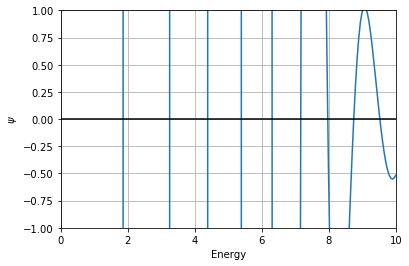

In [72]:
# Plot solution at L as function of E

plt.plot(energies,psiE)
plt.xlabel("Energy"); plt.ylabel(r"$\psi$")
plt.xlim([0,EMax]); plt.ylim([-1,1]);

plt.axhline(0, color='k'); plt.grid(True);
#plt.savefig("figure/psiAtL_EMax="+str(EMax)+".png")
plt.show();

[[10] [42] [10] 'next root' [10] [42] [10] 'next root' [9] [41] [9]
 'next root' [8] [41] [8] 'next root' [10] [41] [10] 'next root' [9] [41]
 [9] 'next root' [8] [41] [9] 'next root' [9] [41] [9] 'next root' [8] [41]
 [8] 'next root']
[ 1.85575704  3.24460765  4.38167126  5.38661375  6.305263    7.16128272
  7.96889165  8.73747323  9.47367874]


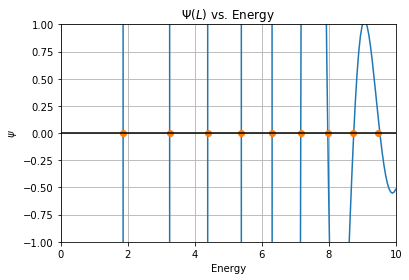

In [82]:
# Root finding

# finds all roots given a "good enough" initial interval [a,b]
# numE,a,b,incr have default values if none are given
# for an interval [a,b], increments b by incr until f(a) and f(b) have opposite signs, then finds root
# after finding a root, shifts a to the root + incr
# stops when b is greater than EMax, or if the number of roots exceeds numE
# uses counts to keep track of the number of function evaluations 
# it takes to for each root finder to find the root. Separates the evalutions counts for different 
# roots with the phrase next roots 
def rootFinder(x,EMax,init,numE=np.inf,a=0.1,b=0.2,incr=0.1):
    roots = np.empty(0)
    counts = np.empty(0)
    while b < EMax and roots.size < numE:
        if (np.sign(psiAtL(a,init,x)) != np.sign(psiAtL(b,init,x))):
            evalcount = [0]
            root = brenth(psiAtL,a,b,args=(init,x,evalcount))
            evalcount1 = [0]            
            root = bisect(psiAtL,a,b,args=(init,x,evalcount1))
            evalcount2 = [0]
            root = brentq(psiAtL,a,b,args=(init,x,evalcount2))
            roots = np.append(roots,root)
            counts= np.append(counts,(evalcount,evalcount1,evalcount2, "next root"))
            a = b; b += incr
        else:
            b += incr
    return (roots,counts)

roots,counts = rootFinder(x,EMax,init)
print(counts)
print(roots)

plt.plot(energies,psiE)
plt.plot(roots,np.zeros(roots.size), 'o')
plt.xlabel("Energy"); plt.ylabel(r"$\psi$")
plt.xlim([0,EMax]); plt.ylim([-1,1]);
plt.title(r"$\Psi(L)$ vs. Energy")
plt.axhline(0,color='k'); plt.grid(True);
#plt.savefig("figures/roots"+ +".png")
plt.show()

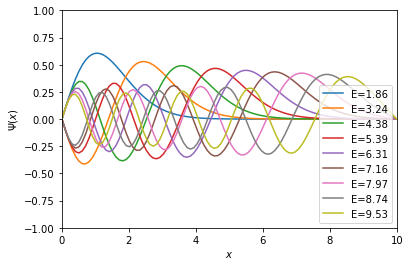

In [74]:
# Plot wavefunction for each energy
sols = np.zeros([nx,roots.size])

for i in range(roots.size):
    if i % 2 != 0:
        init[1] = -1 # set u0=-1 if odd numbered eigenvalue (1st,3rd, ...) to match analytical solution
        sol = odeSolve(init,x,roots[i])
    else:
        init[1] = 1
        sol = odeSolve(init,x,roots[i])    
    psi = sol[:,0]; u = sol[:,1]
    sols[:,i] = psi
    plt.plot(x,psi,label="E="+str(np.around(roots[i],2)))

plt.xlabel(r"$x$"); plt.ylabel(r"$\Psi(x)$");
plt.xlim(0,L); plt.ylim(-1,1);
plt.legend(loc='lower right')
#plt.savefig("figures/" + + ".png")
plt.show()

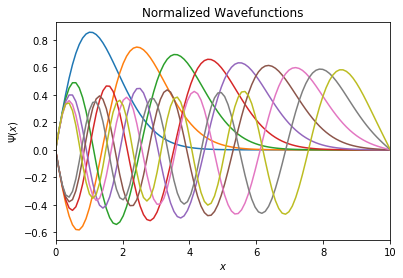

In [75]:
# Normalize wavefunctions
normList = np.zeros(roots.size)

for i in range(roots.size):
    normList[i] = simps(sols[:,i]**2,x)

normSols = sols / np.sqrt(normList)

plt.plot(x,normSols)
plt.xlabel(r"$x$"); plt.ylabel(r"$\Psi(x)$");
plt.xlim(0,L)
plt.title("Normalized Wavefunctions")
#plt.legend()
#plt.savefig("figures/" + + ".png")
plt.show()

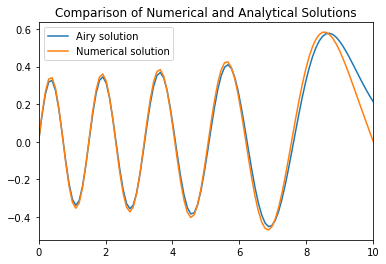

In [76]:
# Compare with analytical solution using Airy functions

airyRoots = np.array([-2.33810,-4.08795,-5.52056,-6.78671,-7.94413,-9.02265,-10.04017,-11.00852,-11.93601])

airyE = -airyRoots / 2**(1/3)

level = 9 # select energy level
#xsub = (x-roots[level-1]) * 2**(1/3)
xsub = (x-airyE[level-1]) * 2**(1/3)
solA = airy(xsub)[0]
norm = simps(solA**2,x)
normSolA = solA / np.sqrt(norm)

plt.plot(x,normSolA,label="Airy solution");
plt.plot(x,normSols[:,level-1],label="Numerical solution")
plt.xlim(0,L)
plt.title("Comparison of Numerical and Analytical Solutions")
plt.legend()
#plt.savefig("figures/airy"+ +".png")
plt.show()

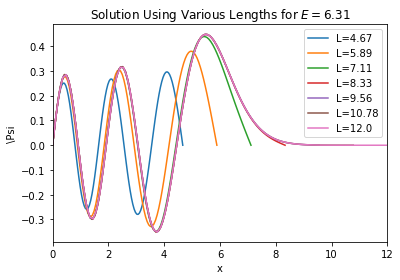

In [78]:
# Plot solutions with varying length

numL = 10 # number of lengths to test
maxL = 12 # maximum length to test
Ls = np.linspace(1,maxL,numL) # array of lengths
level = 5 # select which energy level

for i in range(numL):
    try:
        x = np.linspace(0,Ls[i],nx) # grid
        roots, counts = rootFinder(x,EMax,init,numE=level)
        sol = odeSolve(init,x,roots[level-1])
        psi = sol[:,0]
        plt.plot(x,psi,label="L="+str(np.around(Ls[i],2)))
    except IndexError:
        pass
            
plt.xlim(0,maxL)
plt.xlabel(r"x"); plt.ylabel(r"\Psi");
plt.legend()
plt.title(r"Solution Using Various Lengths for $E="+str(np.around(roots[level-1],2))+"$")
#plt.savefig("figures/varyL_n="+str(level)+".png")
plt.show()